# Stereo Camera Calibration Pipeline

This notebook performs complete stereo camera calibration including:
- Chessboard detection with parallel processing
- Robust RANSAC-based intrinsic calibration
- Stereo pair matching and diversity subsampling
- Stereo calibration and rectification
- Comprehensive visualizations

**Features:**
- Result caching for faster re-runs
- Configurable via YAML file
- Modular utilities for reuse in other scripts

In [1]:
# Add utils to path
import random
import sys
from pathlib import Path

import numpy as np

proj_root = Path.cwd().parent if Path.cwd().name == "calibration" else Path.cwd()
sys.path.insert(0, str(proj_root / "calibration"))

from utils import (
    CalibrationConfig,
    StereoRig,
    build_stereo_pairs_from_detections,
    calibrate_intrinsics_robust,
    calibrate_stereo,
    calibrate_stereo_robust,
    compute_stereo_errors,
    detect_chessboards_parallel,
    group_detections_by_image,
    load_calibration,
    load_kitti_calibration,
    plot_imagepoints_heatmap,
    plot_matched_boards,
    plot_rectification_preview,
    plot_stereo_pair_coverage,
    plot_undistortion_comparison,
    plot_all_imgpoints_overlay,
    save_calibration,
    subsample_stereo_pairs,
    visualize_stereo_matches,
)

# Load configuration
config_path = proj_root / "calibration" / "config.yaml"
config = CalibrationConfig.from_yaml(config_path)
output_dir = proj_root / config.get("data.output_dir")
output_dir.mkdir(parents=True, exist_ok=True)
# Setup cache directory for faster re-runs
cache_dir = proj_root / config.get("data.cache_dir")
if cache_dir:
    cache_dir = cache_dir.resolve()
    print(f"Cache directory: {cache_dir}\n")

vis_mode = config.visualization_mode

print(f"Project root: {proj_root}")
print(f"Configuration loaded from: {config_path}")
print(f"Output folder (visualisations): {output_dir}")
print(f"Visualization mode: {vis_mode}")

Cache directory: C:\Users\fabiu\Documents\GitHub\34759_PfAS_project\calibration\cache

Project root: c:\Users\fabiu\Documents\GitHub\34759_PfAS_project
Configuration loaded from: c:\Users\fabiu\Documents\GitHub\34759_PfAS_project\calibration\config.yaml
Output folder (visualisations): c:\Users\fabiu\Documents\GitHub\34759_PfAS_project\calibration\results
Visualization mode: save


## 2. Load Calibration Images

In [2]:
# Construct paths to calibration images
raw_data_folder = proj_root / config.get("data.raw_data_folder")
calib_left_dir = raw_data_folder / config.get("data.calib_left")
calib_right_dir = raw_data_folder / config.get("data.calib_right")

# Collect image paths
images_left = sorted(calib_left_dir.glob("*.png"))
images_right = sorted(calib_right_dir.glob("*.png"))

print(f"Found {len(images_left)} left images in: {calib_left_dir}")
print(f"Found {len(images_right)} right images in: {calib_right_dir}")

assert len(images_left) > 0 and len(images_right) > 0, "No calibration images found!"

Found 19 left images in: c:\Users\fabiu\Documents\GitHub\34759_PfAS_project\data\34759_final_project_raw\calib\image_02\data
Found 19 right images in: c:\Users\fabiu\Documents\GitHub\34759_PfAS_project\data\34759_final_project_raw\calib\image_03\data


## 3. Detect Chessboards

Detect all chessboard patterns in both left and right calibration images using parallel processing.

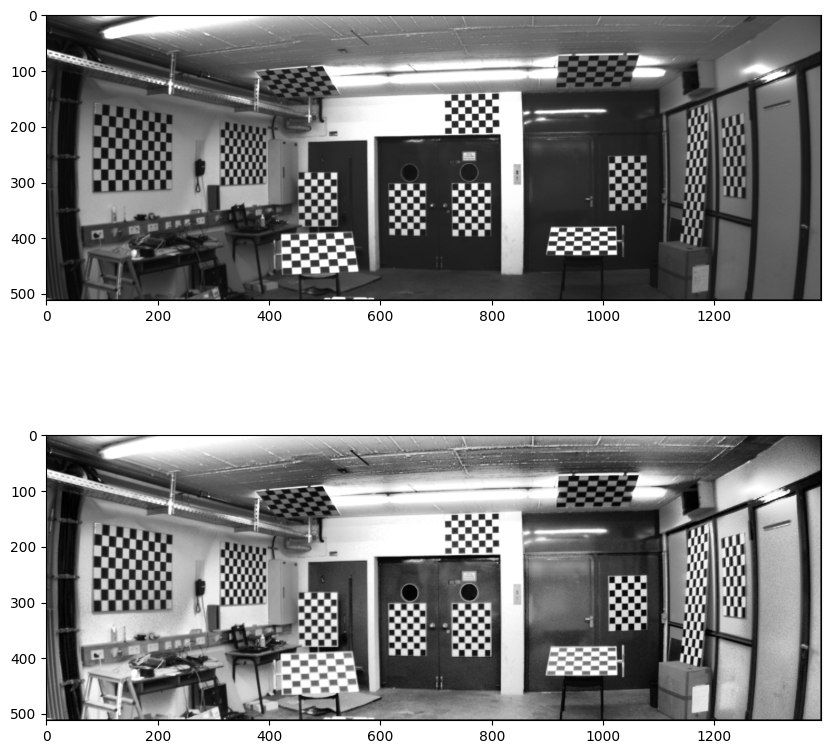

In [3]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread(str(images_right[0]))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(4, 4))
processed = clahe.apply(gray)
# cv2.imshow("clahe",processed)
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.imshow(gray, cmap="gray")
plt.subplot(2, 1, 2)
plt.imshow(processed, cmap="gray")

In [4]:
pattern_sizes = config.pattern_sizes
detection_config = config.config.get("detection", {})

# Extract core parameters
max_boards = detection_config.get("max_boards_per_image", 13)
num_workers = detection_config.get("num_workers", -1)

print(f"Detecting chessboards with patterns: {pattern_sizes}")
print(f"Using {num_workers if num_workers > 0 else 'all'} CPU cores")
if detection_config["use_clahe"] or detection_config["use_bilateral"]:
    print(f"Preprocessing: CLAHE={detection_config['use_clahe']}, Bilateral={detection_config['use_bilateral']}")
print()

# Detect LEFT
print("=== LEFT CAMERA ===")
corners_left, objpoints_left, indices_left, image_size = detect_chessboards_parallel(
    [str(p) for p in images_left],
    progress=True,
    cache_dir=cache_dir,
    **detection_config,
)
print(f"Detected {len(corners_left)} boards in {len(images_left)} images\n")

# Detect RIGHT
print("=== RIGHT CAMERA ===")
corners_right, objpoints_right, indices_right, _ = detect_chessboards_parallel(
    [str(p) for p in images_right],
    progress=True,
    cache_dir=cache_dir,
    **detection_config,
)
print(f"Detected {len(corners_right)} boards in {len(images_right)} images")
print(f"\nImage size: {image_size}")

Detecting chessboards with patterns: [(11, 7), (15, 5), (7, 5)]
Using all CPU cores

=== LEFT CAMERA ===


Detecting boards:   0%|          | 0/19 [00:00<?, ?it/s]

Cached detection results (key=45df13eb...)
Detected 247 boards in 19 images

=== RIGHT CAMERA ===


Detecting boards:   0%|          | 0/19 [00:00<?, ?it/s]

Cached detection results (key=95f72784...)
Detected 209 boards in 19 images

Image size: (1392, 512)


In [5]:
plot_all_imgpoints_overlay(
    corners_left,
    corners_right,
    image_size,
    output_path=output_dir / "all_imgpoints_overlay.png",
    mode=vis_mode,
)

## 4. Robust Intrinsic Calibration

Perform robust RANSAC-based intrinsic calibration for each camera individually.

In [6]:
# Initialize stereo rig
rig = StereoRig()

# Populate detections
rig.left.objpoints = objpoints_left
rig.left.imgpoints = corners_left
rig.left.image_indices = indices_left
rig.left.image_size = image_size

rig.right.objpoints = objpoints_right
rig.right.imgpoints = corners_right
rig.right.image_indices = indices_right
rig.right.image_size = image_size

print("Stereo rig initialized with detection data")

Stereo rig initialized with detection data


In [7]:
# Load robust calibration parameters from config
robust_params = config.config.get("robust_calibration", {})

# Calibrate LEFT camera
print("=" * 60)
print("LEFT CAMERA ROBUST CALIBRATION")
print("=" * 60)

result_left = calibrate_intrinsics_robust(
    rig.left.objpoints,
    rig.left.imgpoints,
    image_size,
    image_indices_list=rig.left.image_indices,
    cache_dir=cache_dir,
    **robust_params,
)

rig.left.K = result_left.K
rig.left.dist = result_left.dist

print("\n" + result_left.summary())

LEFT CAMERA ROBUST CALIBRATION
Loaded cached calibration result (key=bd2cc678...)

Robust Calibration Summary:
  Total detections         : 247
  Removed stage0           : 0
  Removed duplicates (geom): 0
  Removed duplicates (extr): 208
  Diversity selected       : 39
  Removed pre-rejection    : 0
  Removed post-rejection   : 5
  Final boards             : 24
  RMS naive                : 0.1880 px
  RMS final                : 0.0784 px
  Improvement              : 0.1096 px
  Runtime                  : 95.58 s



In [8]:
# Calibrate RIGHT camera
print("\n" + "=" * 60)
print("RIGHT CAMERA ROBUST CALIBRATION")
print("=" * 60)

result_right = calibrate_intrinsics_robust(
    rig.right.objpoints,
    rig.right.imgpoints,
    image_size,
    image_indices_list=rig.right.image_indices,
    cache_dir=cache_dir,
    **robust_params,
)

rig.right.K = result_right.K
rig.right.dist = result_right.dist

print("\n" + result_right.summary())


RIGHT CAMERA ROBUST CALIBRATION
[Stage 1] Naive calibration on up to 50 boards (removed stage0=0/209, geom duplicates=0)


Naive RMS:   0%|          | 0/209 [00:00<?, ?it/s]

[Stage 1a] Extrinsic clustering: kept 34 (removed 175)
[Stage 3] RANSAC search
RANSAC: iters=200 subset_size=8 candidates=34


RANSAC:   0%|          | 0/200 [00:00<?, ?it/s]

c:\Users\fabiu\miniconda3\envs\pfas\lib\site-packages\numpy\linalg\_linalg.py:2780: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


RANSAC best: inliers=27/34 RMS=0.068
[Stage 4] Post-rejection tightening


Post RMS:   0%|          | 0/27 [00:00<?, ?it/s]

Post-rejection: thr=0.100 removed=0
[Stage 5] Final calibration


Final RMS:   0%|          | 0/27 [00:00<?, ?it/s]


Robust Calibration Summary:
  Total detections         : 209
  Removed stage0           : 0
  Removed duplicates (geom): 0
  Removed duplicates (extr): 175
  Diversity selected       : 34
  Removed pre-rejection    : 0
  Removed post-rejection   : 0
  Final boards             : 27
  RMS naive                : 0.1799 px
  RMS final                : 0.0740 px
  Improvement              : 0.1059 px
  Runtime                  : 82.16 s



In [9]:
rig.left.K, rig.left.dist, rig.right.K, rig.right.dist

(array([[1.01068724e+03, 0.00000000e+00, 6.95312218e+02],
        [0.00000000e+00, 1.00933400e+03, 2.56043007e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-0.37989883,  0.47711489,  0.00089773, -0.00761032, -0.57193363]]),
 array([[991.62768312,   0.        , 700.34571874],
        [  0.        , 994.44435916, 255.44206826],
        [  0.        ,   0.        ,   1.        ]]),
 array([[-4.69007604e-01,  6.38856206e-01,  4.77143638e-04,
         -4.66774066e-03, -5.25655250e-01]]))

## 5. Visualize Intrinsic Calibration Results

In [10]:
# Undistortion comparison - LEFT
sample_left = str(random.choice(images_left))
plot_undistortion_comparison(
    sample_left,
    rig.left.K,
    rig.left.dist,
    camera_name="LEFT",
    output_path=output_dir / "undistortion_left.png",
    mode=vis_mode,
)

# Undistortion comparison - RIGHT
sample_right = str(random.choice(images_right))
plot_undistortion_comparison(
    sample_right,
    rig.right.K,
    rig.right.dist,
    camera_name="RIGHT",
    output_path=output_dir / "undistortion_right.png",
    mode=vis_mode,
)

In [11]:
# Coverage heatmaps
heatmap_bins = config.get("visualization.heatmap_bins", 40)

plot_imagepoints_heatmap(
    result_left.final_imgpoints,
    image_size,
    camera_name="LEFT",
    output_path=output_dir / "heatmap_left.png",
    mode=vis_mode,
    bins=heatmap_bins,
)

plot_imagepoints_heatmap(
    result_right.final_imgpoints,
    image_size,
    camera_name="RIGHT",
    output_path=output_dir / "heatmap_right.png",
    mode=vis_mode,
    bins=heatmap_bins,
)


LEFT Coverage Statistics:
  Total points: 966
  Total boards: 24
  X range: [163.7, 1166.7] (coverage: 72.1%)
  Y range: [151.0, 465.0] (coverage: 61.3%)

RIGHT Coverage Statistics:
  Total points: 1071
  Total boards: 27
  X range: [98.4, 1068.1] (coverage: 69.7%)
  Y range: [82.7, 453.6] (coverage: 72.4%)


## 6. Build Stereo Pairs from Detected Boards

Match chessboards between left and right images to create stereo calibration pairs. This uses the already-detected boards from section 3.

In [12]:
# Build stereo pairs by matching already-detected boards
matching_params = config.config.get("matching", {})
square_size = config.square_size

stereo_objpoints, stereo_imgpoints_left, stereo_imgpoints_right, matching_metadata = build_stereo_pairs_from_detections(
    corners_left,
    objpoints_left,
    indices_left,
    corners_right,
    objpoints_right,
    indices_right,
    dy_thresh=matching_params.get("dy_thresh", 12.0),
    scale_ratio_thresh=matching_params.get("scale_ratio_thresh", 0.25),
    method=matching_params.get("method", "hungarian"),
    cache_dir=cache_dir,
    progress=True,
)

# Scale object points by square size
for objp in stereo_objpoints:
    objp *= float(square_size)

print("\nMatching statistics:")
print(f"  Total pairs processed: {matching_metadata['total_pairs_processed']}")
print(f"  Total boards matched: {matching_metadata['total_boards_matched']}")
if matching_metadata["matches_per_pair"]:
    print(
        f"  Average matches per pair: {sum(matching_metadata['matches_per_pair']) / len(matching_metadata['matches_per_pair']):.1f}"
    )

# Visualize a few example matched pairs
visualize_stereo_matches(
    corners_left,
    objpoints_left,
    indices_left,
    corners_right,
    objpoints_right,
    indices_right,
    images_left,
    images_right,
    matching_metadata,
    output_dir,
    vis_mode=vis_mode,
    max_pairs=3,
)

Loaded cached stereo_matching results (key=e0c47367...)
Total matched boards: 208

Matching statistics:
  Total pairs processed: 19
  Total boards matched: 208
  Average matches per pair: 10.9

Visualizing matches for pairs: [0, 9, 18]


## 6b. Subsample Stereo Pairs using Extrinsic Deduplication

Apply extrinsic deduplication to stereo pairs to cluster by pose similarity and keep the best from each cluster, ensuring geometric diversity for stereo calibration.

In [13]:
# Subsample stereo pairs using extrinsic deduplication
subsample_config = config.config.get("stereo_subsampling", {})
if subsample_config.get("enabled", True):
    print("\n" + "=" * 60)
    print("STEREO PAIR EXTRINSIC DEDUPLICATION")
    print("=" * 60)

    stereo_objpoints_subs, stereo_imgpoints_subs_left, stereo_imgpoints_subs_right, kept_indices = (
        subsample_stereo_pairs(
            stereo_objpoints,
            stereo_imgpoints_left,
            stereo_imgpoints_right,
            rig.left.K,
            rig.left.dist,
            angle_thresh_deg=subsample_config.get("angle_thresh_deg", 0.5),
            translation_thresh=subsample_config.get("translation_thresh", 0.02),
            keep_per_cluster=subsample_config.get("keep_per_cluster", 1),
            verbose=True,
        )
    )

    # Visualize spatial coverage of stereo pairs
    plot_stereo_pair_coverage(
        stereo_imgpoints_left,
        stereo_imgpoints_right,
        image_size,
        kept_indices=kept_indices,
        output_path=output_dir / "stereo_pair_coverage.png",
        mode=vis_mode,
    )
    print("Stereo pair coverage visualization saved")
else:
    stereo_objpoints_subs = stereo_objpoints
    stereo_imgpoints_subs_left = stereo_imgpoints_left
    stereo_imgpoints_subs_right = stereo_imgpoints_right
    print("\nStereo pair subsampling disabled, using all matched pairs")


STEREO PAIR EXTRINSIC DEDUPLICATION
Stereo extrinsic deduplication: 208 → 11 pairs
  Criteria: angle_thresh=400°, translation_thresh=0.12, keep_per_cluster=1
Stereo pair coverage visualization saved


In [14]:
# Overlay plot: use the visualization helper to plot all left/right points
plot_all_imgpoints_overlay(
    stereo_imgpoints_subs_left,
    stereo_imgpoints_subs_right,
    image_size,
    output_path=output_dir / "all_subsampled_imgpoints_overlay.png",
    mode=vis_mode,
)

## 7. Stereo Calibration and Rectification

In [15]:
provided_calib_path = proj_root / "data" / "calib_cam_to_cam.txt"
rig_provided = load_kitti_calibration(provided_calib_path)
print(f"R: {rig_provided.R}, T: {rig_provided.T}")

KITTI calibration loaded from c:\Users\fabiu\Documents\GitHub\34759_PfAS_project\data\calib_cam_to_cam.txt
R: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]], T: [[-0.53552388]
 [ 0.00666445]
 [-0.01007482]]


In [16]:
# Stereo calibration parameters
stereo_params = config.config.get("stereo", {})
use_frankenstein = config.get("use_frankenstein", False)

print("\n" + "=" * 60)
print("STEREO CALIBRATION")
print("=" * 60 + "\n")

r_mat = None
t_vec = None
# r_mat = np.eye(3)
# t_vec = np.array([-0.5, 0, 0])

# Use robust RANSAC-like calibration
import copy

rig_frankenstein = copy.deepcopy(rig)
if use_frankenstein:
    rig_frankenstein.left.K = rig_provided.left.K
    rig_frankenstein.left.dist = rig_provided.left.dist
    rig_frankenstein.right.K = rig_provided.right.K
    rig_frankenstein.right.dist = rig_provided.right.dist

rig_frankenstein, best_indices = calibrate_stereo_robust(
    rig_frankenstein,
    stereo_objpoints_subs,
    stereo_imgpoints_subs_left,
    stereo_imgpoints_subs_right,
    image_size,
    ransac_iterations=100,
    subset_size=min(8, len(stereo_objpoints_subs)),
    r_mat=r_mat,
    t_vec=t_vec,
    **stereo_params,
)

print("\nStereo calibration complete!")
print(f"  RMS error: {rig_frankenstein.stereo_rms:.4f} px")
print(f"  Baseline: {rig_frankenstein.baseline:.4f} m")
print(f"  Left ROI: {rig_frankenstein.left.roi}")
print(f"  Right ROI: {rig_frankenstein.right.roi}")
print(f"  Best subset size: {len(best_indices)}")
print(f"R: {rig_frankenstein.R}, T: {rig_frankenstein.T}")


STEREO CALIBRATION

Robust Stereo Calibration: 11 pairs, 100 iters, subset=8
  Iter 0: FULL -> RMS=13.2322 px (Train RMS=9.0950)
  Iter 1: SUB(8) -> RMS=12.7553 px (Train RMS=0.1291)
  Iter 2: SUB(8) -> RMS=13.3989 px (Train RMS=10.8688)
  Iter 3: SUB(8) -> RMS=13.8067 px (Train RMS=10.7382)
  Iter 4: SUB(8) -> RMS=13.6303 px (Train RMS=10.7657)
  Iter 5: SUB(8) -> RMS=13.4119 px (Train RMS=10.2185)
  Iter 6: SUB(8) -> RMS=13.6152 px (Train RMS=10.7714)
  Iter 7: SUB(8) -> RMS=13.5729 px (Train RMS=10.7649)
  Iter 8: SUB(8) -> RMS=13.4773 px (Train RMS=10.1682)
  Iter 9: SUB(8) -> RMS=12.7552 px (Train RMS=0.1157)
  Iter 10: SUB(8) -> RMS=12.7552 px (Train RMS=0.1248)
  Iter 11: SUB(8) -> RMS=12.7550 px (Train RMS=0.1220)
  Iter 12: SUB(8) -> RMS=12.7551 px (Train RMS=0.1258)
  Iter 13: SUB(8) -> RMS=13.1090 px (Train RMS=11.7657)
  Iter 14: SUB(8) -> RMS=12.7549 px (Train RMS=0.1241)
  Iter 15: SUB(8) -> RMS=13.4713 px (Train RMS=10.8373)
  Iter 16: SUB(8) -> RMS=13.0923 px (Train RM

In [17]:
import cv2

rect_flags = cv2.CALIB_ZERO_DISPARITY
# rect_flags = 0
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    rig_provided.left.K,
    rig_provided.left.dist,
    rig_provided.right.K,
    rig_provided.right.dist,
    image_size,
    rig_provided.R,
    rig_provided.T,
    flags=rect_flags,
    alpha=0.6,
)


# Compute rectification maps
rig_provided.left.map1, rig_provided.left.map2 = cv2.initUndistortRectifyMap(
    rig_provided.left.K, rig_provided.left.dist, rig_provided.left.R, rig_provided.left.P, image_size, cv2.CV_16SC2
)
rig_provided.right.map1, rig_provided.right.map2 = cv2.initUndistortRectifyMap(
    rig_provided.right.K, rig_provided.right.dist, rig_provided.right.R, rig_provided.right.P, image_size, cv2.CV_16SC2
)

In [18]:
rig_provided.left.P, P1, rig_provided.right.P, P2, roi1, roi2

(array([[ 7.070493e+02,  0.000000e+00,  6.040814e+02,  4.575831e+01],
        [ 0.000000e+00,  7.070493e+02,  1.805066e+02, -3.454157e-01],
        [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  4.981016e-03]]),
 array([[740.05892419,   0.        , 670.50526428,   0.        ],
        [  0.        , 740.05892419, 226.46346283,   0.        ],
        [  0.        ,   0.        ,   1.        ,   0.        ]]),
 array([[ 7.070493e+02,  0.000000e+00,  6.040814e+02, -3.341081e+02],
        [ 0.000000e+00,  7.070493e+02,  1.805066e+02,  2.330660e+00],
        [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  3.201153e-03]]),
 array([[ 740.05892419,    0.        ,  670.50526428, -396.42003753],
        [   0.        ,  740.05892419,  226.46346283,    0.        ],
        [   0.        ,    0.        ,    1.        ,    0.        ]]),
 (7, 37, 1371, 408),
 (0, 26, 1392, 435))

In [19]:
rig_frankenstein.left.P, rig_frankenstein.right.P, rig_frankenstein.left.roi, rig_frankenstein.right.roi

(array([[970.70437023,   0.        , 495.12445068,   0.        ],
        [  0.        , 970.70437023, 223.30386734,   0.        ],
        [  0.        ,   0.        ,   1.        ,   0.        ]]),
 array([[ 970.70437023,    0.        ,  495.12445068, -237.74155483],
        [   0.        ,  970.70437023,  223.30386734,    0.        ],
        [   0.        ,    0.        ,    1.        ,    0.        ]]),
 (0, 0, 1392, 511),
 (0, 0, 1392, 512))

## 8. Visualize Rectification Results

In [20]:
# Pick a random stereo pair for visualization
test_idx = random.randint(0, len(images_left) - 1)
n_guides = config.get("visualization.rectification_guide_lines", 12)

plot_rectification_preview(
    str(images_left[test_idx]),
    str(images_right[test_idx]),
    rig_frankenstein.left.map1,
    rig_frankenstein.left.map2,
    rig_frankenstein.right.map1,
    rig_frankenstein.right.map2,
    roi_left=rig_frankenstein.left.roi,
    roi_right=rig_frankenstein.right.roi,
    n_guides=n_guides,
    output_path=output_dir / f"rectification_preview_{test_idx}.png",
    mode=vis_mode,
)

plot_rectification_preview(
    str(images_left[test_idx]),
    str(images_right[test_idx]),
    rig_provided.left.map1,
    rig_provided.left.map2,
    rig_provided.right.map1,
    rig_provided.right.map2,
    roi_left=rig_provided.left.roi,
    roi_right=rig_provided.right.roi,
    n_guides=n_guides,
    output_path=output_dir / f"rectification_provided_{test_idx}.png",
    mode=vis_mode,
)

print(f"Rectification preview saved for image pair {test_idx}")

Rectification preview saved for image pair 14


## 9. Export Calibration Parameters

In [21]:
# Export configuration
export_format = config.get("export.format", "yaml")
output_filename = config.get("export.output_filename", "stereo_calibration.yaml")
output_path = output_dir / output_filename

save_calibration(
    rig_frankenstein,
    output_path,
    fmt=export_format,
    include_metadata=config.get("export.include_metadata", True),
)

print(f"\nCalibration results exported to: {output_path}")
print(f"Format: {export_format}")

Calibration saved to c:\Users\fabiu\Documents\GitHub\34759_PfAS_project\calibration\results\stereo_calibration.yaml

Calibration results exported to: c:\Users\fabiu\Documents\GitHub\34759_PfAS_project\calibration\results\stereo_calibration.yaml
Format: yaml


## 10. Verify Saved Calibration (Optional)

Load the saved calibration back and verify parameters.

In [22]:
# Load and verify
rig_loaded = load_calibration(output_path)

print("\nVerification:")
print(f"  Left camera calibrated: {rig_loaded.left.is_calibrated()}")
print(f"  Right camera calibrated: {rig_loaded.right.is_calibrated()}")
print(f"  Stereo calibrated: {rig_loaded.is_stereo_calibrated()}")
print(f"  Rectified: {rig_loaded.is_rectified()}")
print(f"  Baseline: {rig_loaded.baseline:.4f} m")

# Compare key parameters
import numpy as np

k_diff = np.linalg.norm(rig_frankenstein.left.K - rig_loaded.left.K)
print(f"  K matrix difference (L2 norm): {k_diff:.2e}")

Calibration loaded from c:\Users\fabiu\Documents\GitHub\34759_PfAS_project\calibration\results\stereo_calibration.yaml

Verification:
  Left camera calibrated: True
  Right camera calibrated: True
  Stereo calibrated: True
  Rectified: False
  Baseline: 0.5342 m
  K matrix difference (L2 norm): 0.00e+00


## Summary

Calibration pipeline complete! The following files have been generated:

- Calibration parameters: `{output_dir}/{output_filename}`
- Visualization outputs: `{output_dir}/*.png`

Use `load_calibration()` to load the parameters in other scripts.

## 11. Compare with Provided Calibration

Compare the calculated calibration parameters with the provided `calib_cam_to_cam.txt` file.

In [23]:
# Path to provided calibration file
provided_calib_path = proj_root / "data" / "calib_cam_to_cam.txt"

if provided_calib_path.exists():
    print(f"Loading provided calibration from: {provided_calib_path}")
    rig_provided = load_kitti_calibration(provided_calib_path)

    print("\n" + "=" * 60)
    print("CALIBRATION COMPARISON (Calculated vs Provided)")
    print("=" * 60)

    def compare_matrix(name, mat_calc, mat_prov):
        if mat_calc is None or mat_prov is None:
            print(f"\n{name}: Missing data for comparison")
            return

        diff = np.abs(mat_calc - mat_prov)
        abs_err = np.mean(diff)

        # Avoid division by zero
        denom = np.abs(mat_prov)
        denom[denom < 1e-9] = 1.0
        perc_err = np.mean(diff / denom) * 100.0

        print(f"\n{name}:")
        print(f"  Mean Abs Diff: {abs_err:.6f}")
        print(f"  Mean % Diff:   {perc_err:.4f}%")
        print(f"  Max Diff:      {np.max(diff):.6f}")

    # Compare Intrinsics
    print("\n--- LEFT CAMERA ---")
    compare_matrix("K Matrix", rig_frankenstein.left.K, rig_provided.left.K)
    compare_matrix("Distortion", rig_frankenstein.left.dist.flatten()[:5], rig_provided.left.dist.flatten())

    print("\n--- RIGHT CAMERA ---")
    compare_matrix("K Matrix", rig_frankenstein.right.K, rig_provided.right.K)
    compare_matrix("Distortion", rig_frankenstein.right.dist.flatten()[:5], rig_provided.right.dist.flatten())

    # Compare Stereo
    print("\n--- STEREO EXTRINSICS ---")
    if rig_frankenstein.baseline is not None and rig_provided.baseline is not None:
        b_calc = rig_frankenstein.baseline
        b_prov = rig_provided.baseline
        diff = abs(b_calc - b_prov)
        perc = (diff / b_prov) * 100.0
        print("\nBaseline:")
        print(f"  Calculated: {b_calc:.6f} m")
        print(f"  Provided:   {b_prov:.6f} m")
        print(f"  Diff:       {diff:.6f} m ({perc:.4f}%)")

    # Compare Translation Vector
    # Note: rig.T is usually [ -baseline, 0, 0 ] for rectified, but raw T might differ
    # rig_provided.T was calculated from T_03 - T_02
    compare_matrix("Translation (T)", rig_frankenstein.T, rig_provided.T)

    # Calculate RMS of provided calibration on our detected points
    print("\n--- REPROJECTION ERROR COMPARISON ---")

    # Calculate RMS for our calibration (on all points)
    errors_ours = compute_stereo_errors(
        stereo_objpoints_subs,
        stereo_imgpoints_subs_left,
        stereo_imgpoints_subs_right,
        rig_frankenstein.left.K,
        rig_frankenstein.left.dist,
        rig_frankenstein.right.K,
        rig_frankenstein.right.dist,
        rig_frankenstein.R,
        rig_frankenstein.T,
    )
    rms_ours = np.sqrt(np.mean(errors_ours**2))

    # Calculate RMS for provided calibration
    # Note: Provided calibration might assume rectified images or different distortion model
    # We use the raw K, D, R, T loaded from the file
    errors_prov = compute_stereo_errors(
        stereo_objpoints_subs,
        stereo_imgpoints_subs_left,
        stereo_imgpoints_subs_right,
        rig_provided.left.K,
        rig_provided.left.dist,
        rig_provided.right.K,
        rig_provided.right.dist,
        rig_provided.R,
        rig_provided.T,
    )
    # Filter out infinite errors (failed PnP)
    valid_errors_prov = errors_prov[np.isfinite(errors_prov)]
    if len(valid_errors_prov) > 0:
        rms_prov = np.sqrt(np.mean(valid_errors_prov**2))
        print("\nRMS Error on detected chessboards:")
        print(f"  Calculated Calibration: {rms_ours:.4f} px")
        print(f"  Provided Calibration:   {rms_prov:.4f} px")
        print(f"  Valid points for provided: {len(valid_errors_prov)}/{len(errors_prov)}")
    else:
        print("\nCould not calculate RMS for provided calibration (PnP failed for all points)")

else:
    print(f"Provided calibration file not found at: {provided_calib_path}")

Loading provided calibration from: c:\Users\fabiu\Documents\GitHub\34759_PfAS_project\data\calib_cam_to_cam.txt
KITTI calibration loaded from c:\Users\fabiu\Documents\GitHub\34759_PfAS_project\data\calib_cam_to_cam.txt

CALIBRATION COMPARISON (Calculated vs Provided)

--- LEFT CAMERA ---

K Matrix:
  Mean Abs Diff: 0.000000
  Mean % Diff:   0.0000%
  Max Diff:      0.000000

Distortion:
  Mean Abs Diff: 0.000000
  Mean % Diff:   0.0000%
  Max Diff:      0.000000

--- RIGHT CAMERA ---

K Matrix:
  Mean Abs Diff: 0.000000
  Mean % Diff:   0.0000%
  Max Diff:      0.000000

Distortion:
  Mean Abs Diff: 0.000000
  Mean % Diff:   0.0000%
  Max Diff:      0.000000

--- STEREO EXTRINSICS ---

Baseline:
  Calculated: 0.534187 m
  Provided:   0.535660 m
  Diff:       0.001473 m (0.2750%)

Translation (T):
  Mean Abs Diff: 0.000868
  Mean % Diff:   4.5510%
  Max Diff:      0.001482

--- REPROJECTION ERROR COMPARISON ---

RMS Error on detected chessboards:
  Calculated Calibration: 12.7546 px
  P

In [24]:
(
    (
        rig_frankenstein.left.K,
        rig_frankenstein.left.dist,
        rig_frankenstein.right.K,
        rig_frankenstein.right.dist,
        rig_frankenstein.R,
        rig_frankenstein.T,
    ),
    (
        rig_provided.left.K,
        rig_provided.left.dist,
        rig_provided.right.K,
        rig_provided.right.dist,
        rig_provided.R,
        rig_provided.T,
    ),
)

((array([[956.9475,   0.    , 693.9767],
         [  0.    , 952.2352, 238.6081],
         [  0.    ,   0.    ,   1.    ]]),
  array([-0.3750956 ,  0.2076838 ,  0.00043485,  0.00160316, -0.07469243]),
  array([[901.1007,   0.    , 698.2947],
         [  0.    , 897.0639, 237.7447],
         [  0.    ,   0.    ,   1.    ]]),
  array([-3.686011e-01,  1.908666e-01, -5.689518e-04,  3.332341e-04,
         -6.302873e-02]),
  array([[ 0.99946956,  0.02192846, -0.02407771],
         [-0.02188812,  0.99975855,  0.00193759],
         [ 0.02411438, -0.00140954,  0.99970821]]),
  array([[-0.53404224],
         [ 0.00622572],
         [-0.01075923]])),
 (array([[956.9475,   0.    , 693.9767],
         [  0.    , 952.2352, 238.6081],
         [  0.    ,   0.    ,   1.    ]]),
  array([-0.3750956 ,  0.2076838 ,  0.00043485,  0.00160316, -0.07469243]),
  array([[901.1007,   0.    , 698.2947],
         [  0.    , 897.0639, 237.7447],
         [  0.    ,   0.    ,   1.    ]]),
  array([-3.686011e-01,  1